# <center> Построение адаптивных моделей в statsmodels </center>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

В библиотеке **statsmodels** реализованы модели прогнозирования, в т. ч. модель Хольта-Уинтерса. Все рассмотренные ранее модели, в основе которых лежит метод экспоненциального сглаживания, реализованы в модуле `statsmodels.tsa.holtwinters`.

## 1. Простое экспоненциальное сглаживание

Функция `SimpleExpSmoothing` предназначена для построения простого экспоненциального сглаживания. Построим модель экспоненциального сглаживания для прогнозирования объемов пассажирских авиаперевозок в Австралии.

In [2]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [3]:
ausair = pd.read_csv('data/ausair.csv', index_col='Year', parse_dates=True)
ausair = ausair['Passengers'][20:]
ausair.index = pd.DatetimeIndex(ausair.index, freq='YS')

В качестве аргумента фукнции `SimpleExpSmoothing` выступает исходный временной ряд. Для опредения оптимального параметра сглаживания $\alpha$ воспользуемся методом `fit()` модели.

In [4]:
ses = SimpleExpSmoothing(ausair, initialization_method='estimated').fit()
# initialization_method='estimated' - l0, b0, alpha подбираются по МНК

Помимо параметра сглаживания $\alpha$ функция `SimpleExpSmoothing` определяет начальное значение уровня $l_0$, которое также влияет на результат прогнозирования. Значения $\alpha$ и $l_0$ можно задать вручную:

In [5]:
y0 = ausair.values[0]
ses_lvl = SimpleExpSmoothing(ausair, initialization_method='known', initial_level=y0) # l0, b0 - сюда
ses_lvl = ses_lvl.fit(smoothing_level=0.8, optimized=False) # alpha, beta, gamma - здесь, optimized=False - для того, чтобы брал наш уровень

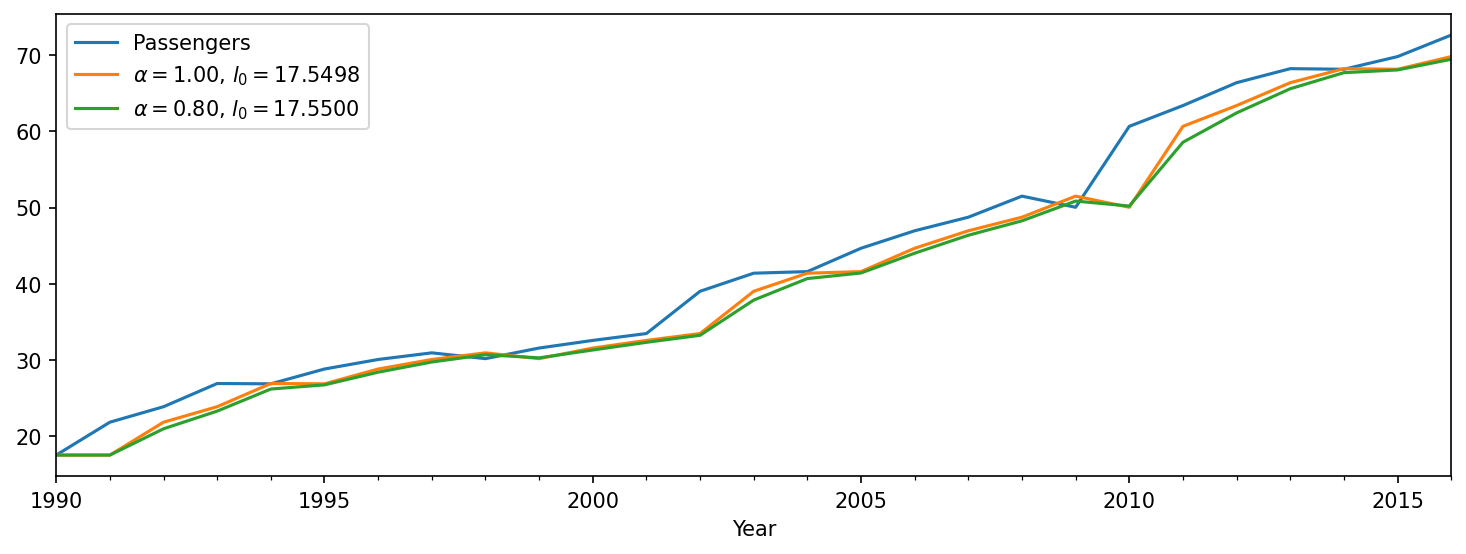

In [6]:
plt.figure(figsize=(12, 4), dpi=150)
ausair.plot(legend=True)
ses.fittedvalues.rename(r'$\alpha=%.2f$' % ses.model.params['smoothing_level'] + ', ' +
                        r'$l_0=%.4f$' % ses.model.params['initial_level']).plot(legend=True)
ses_lvl.fittedvalues.rename(r'$\alpha=%.2f$' % ses_lvl.model.params['smoothing_level'] + ', ' +
                            r'$l_0=%.4f$' % ses_lvl.model.params['initial_level']).plot(legend=True)
plt.show()

Для построения прогноза воспользуемся методом `.forecast()`, указав горизонт прогнозирования.

In [7]:
ses_forecast = ses.forecast(10)
ses_lvl_forecast = ses_lvl.forecast(10)

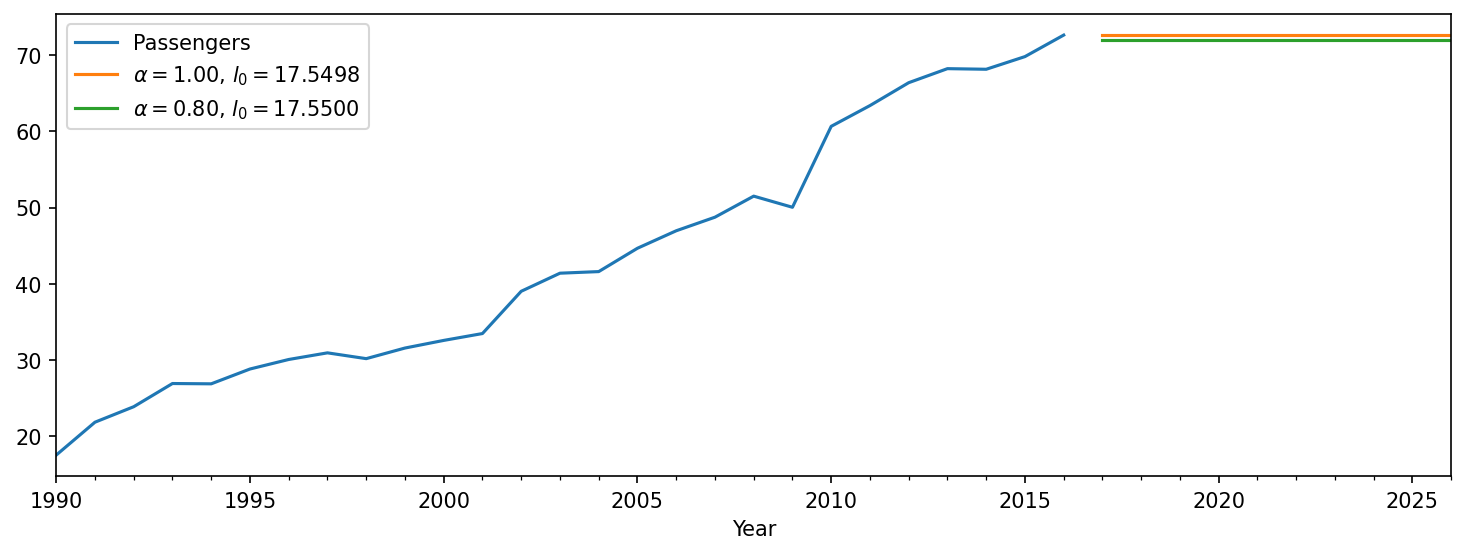

In [8]:
plt.figure(figsize=(12,4), dpi=150)
ausair.plot(legend=True)
ses_forecast.rename(r'$\alpha=%.2f$' % ses.model.params['smoothing_level'] + ', ' +
                    r'$l_0=%.4f$' % ses.model.params['initial_level']).plot(legend=True)
ses_lvl_forecast.rename(r'$\alpha=%.2f$' % ses_lvl.model.params['smoothing_level'] + ', ' +
                        r'$l_0=%.4f$' % ses_lvl.model.params['initial_level']).plot(legend=True)
plt.show()

**Важно!** Если не задан период наблюдений, то statsmodels может построить прогноз с неожиданного индекса. Чтобы явно передать, для каких дат необходимо построить прогноз, можно воспользоваться методом `.predict(start, end)`.

In [9]:
ausair.index

DatetimeIndex(['1990-01-01', '1991-01-01', '1992-01-01', '1993-01-01',
               '1994-01-01', '1995-01-01', '1996-01-01', '1997-01-01',
               '1998-01-01', '1999-01-01', '2000-01-01', '2001-01-01',
               '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01',
               '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01'],
              dtype='datetime64[ns]', name='Year', freq='AS-JAN')

In [8]:
start = ausair.index[-1] + pd.DateOffset(years=1)
end = start + pd.DateOffset(years=9)
start, end

(Timestamp('2017-01-01 00:00:00'), Timestamp('2026-01-01 00:00:00'))

In [9]:
ses.predict(start=start, end=end)

2017-01-01    72.6
2018-01-01    72.6
2019-01-01    72.6
2020-01-01    72.6
2021-01-01    72.6
2022-01-01    72.6
2023-01-01    72.6
2024-01-01    72.6
2025-01-01    72.6
2026-01-01    72.6
Freq: AS-JAN, dtype: float64

## 2. Метод Хольта

Для рядов с трендом можно воспользоваться функцией `Holt`.

In [10]:
from statsmodels.tsa.holtwinters import Holt

In [11]:
holt = Holt(ausair, initialization_method='estimated').fit()

b0 = ausair.values[1] - ausair.values[0]
holt_initial = Holt(ausair, initialization_method='known', initial_level=y0, initial_trend=b0)
holt_initial = holt_initial.fit(smoothing_level=0.59, smoothing_trend=0.43, optimized=False)

In [12]:
alpha = holt.model.params['smoothing_level']
beta = holt.model.params['smoothing_trend']
l0 = holt.model.params['initial_level']
b0 = holt.model.params['initial_trend']
print('Best params: ')
print('alpha = {:.2f},'.format(alpha), 'beta = {:.2f}'.format(beta))
print('l0  = {:.2f},'.format(l0), 'b0 = {:.2f}'.format(b0))

Best params: 
alpha = 0.82, beta = 0.00
l0  = 15.85, b0 = 2.10


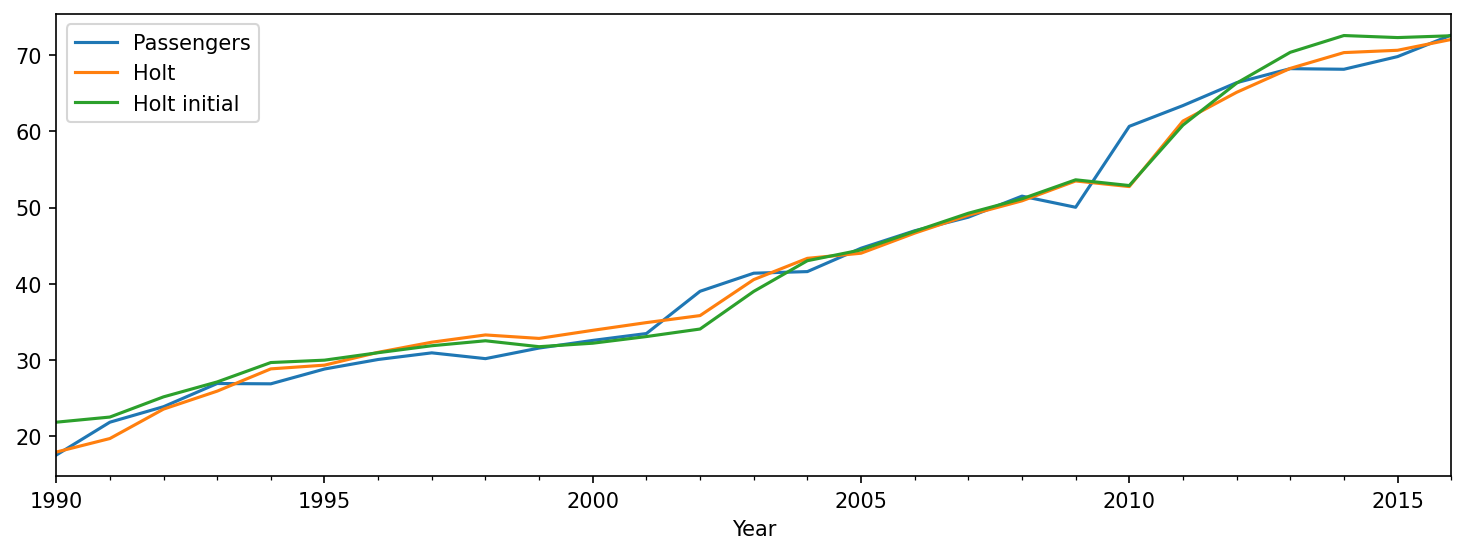

In [13]:
plt.figure(figsize=(12,4), dpi=150)
ausair.plot(legend=True)
holt.fittedvalues.rename('Holt').plot(legend=True)
holt_initial.fittedvalues.rename('Holt initial').plot(legend=True)
plt.show()

In [ ]:
#version 0.12.2
#pip install -U statsmodels

In [14]:
import statsmodels
statsmodels.__version__

'0.13.5'

In [15]:
holt_damped = Holt(ausair, damped_trend=True, initialization_method='estimated').fit()

b0 = ausair.values[1] - ausair.values[0]
holt_damped_initial = Holt(ausair, damped_trend=True, initialization_method='known', 
                           initial_level=y0, initial_trend=b0)
holt_damped_initial = holt_damped_initial.fit(smoothing_level=0.39, 
                                              smoothing_trend=0.10,
                                              damping_trend=0.9,
                                              optimized=False)

In [16]:
alpha = holt_damped.model.params['smoothing_level']
beta = holt_damped.model.params['smoothing_trend']
l0 = holt_damped.model.params['initial_level']
b0 = holt_damped.model.params['initial_trend']
phi = holt_damped.model.params['damping_trend']
print('Best params: ')
print('alpha = {:.2f},'.format(alpha), 'beta = {:.2f}'.format(beta), 'phi = {:.2f}'.format(phi))
print('l0  = {:.2f},'.format(l0), 'b0 = {:.2f}'.format(b0))

Best params: 
alpha = 0.84, beta = 0.00 phi = 0.99
l0  = 15.65, b0 = 2.24


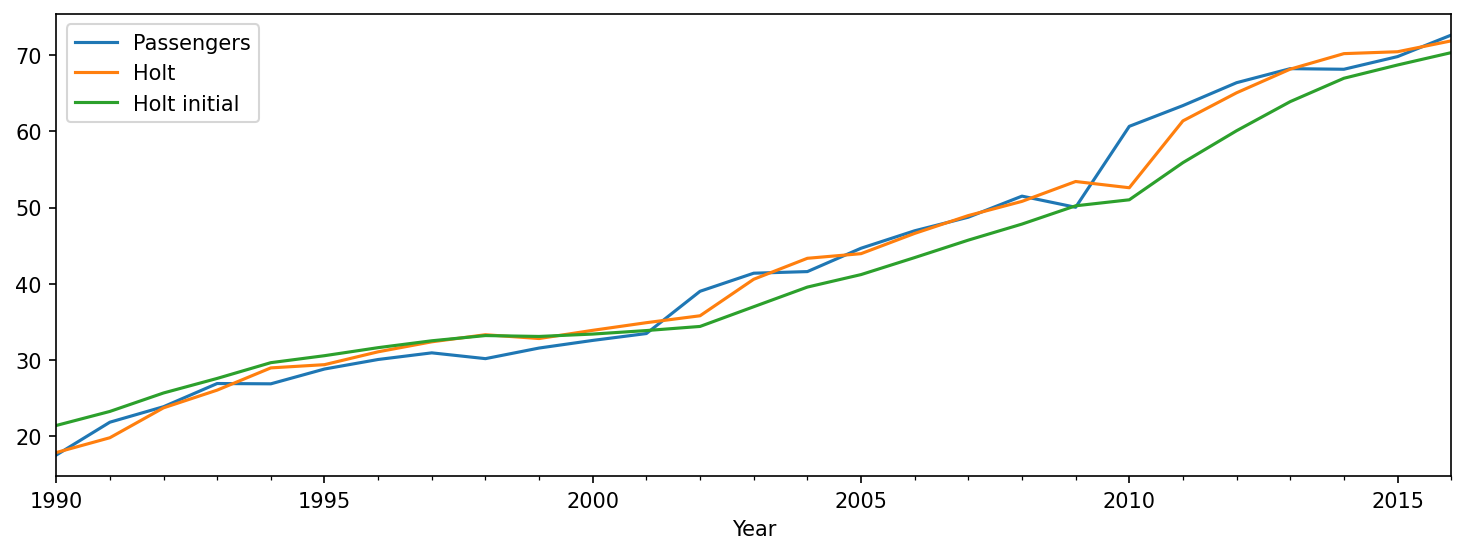

In [17]:
plt.figure(figsize=(12,4), dpi=150)
ausair.plot(legend=True)
holt_damped.fittedvalues.rename('Holt').plot(legend=True)
holt_damped_initial.fittedvalues.rename('Holt initial').plot(legend=True)
plt.show()

## 3. Метод Хольта-Уинтерса

Модель Хольта-Уинтерса для рядов с сезонностью реализована в `ExponentialSmoothing`.

In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

<a href='https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html'>Документация</a>

<div class="alert alert-info">

<h3> Задание</h3>
<p></p>
<ul>1. Постройте модель Хольта-Уинтерса для ряда <b>passengers.csv</b>.</ul>
<ul>2. Оцените качество аппроксимации с помощью среднеквадратичной ошибки.</ul>
<ul>3. Постройте прогноз на 3 года вперед и отобразите его на графике.</ul>
<p></p>
  
</div>

In [10]:
passengers = pd.read_csv('data/passengers.csv', index_col='date', parse_dates=True)

In [11]:
passengers.index = pd.DatetimeIndex(passengers.index, freq='MS')

In [16]:
es = ExponentialSmoothing(passengers, trend='add', seasonal_periods=12, seasonal='mul', initialization_method='estimated').fit()

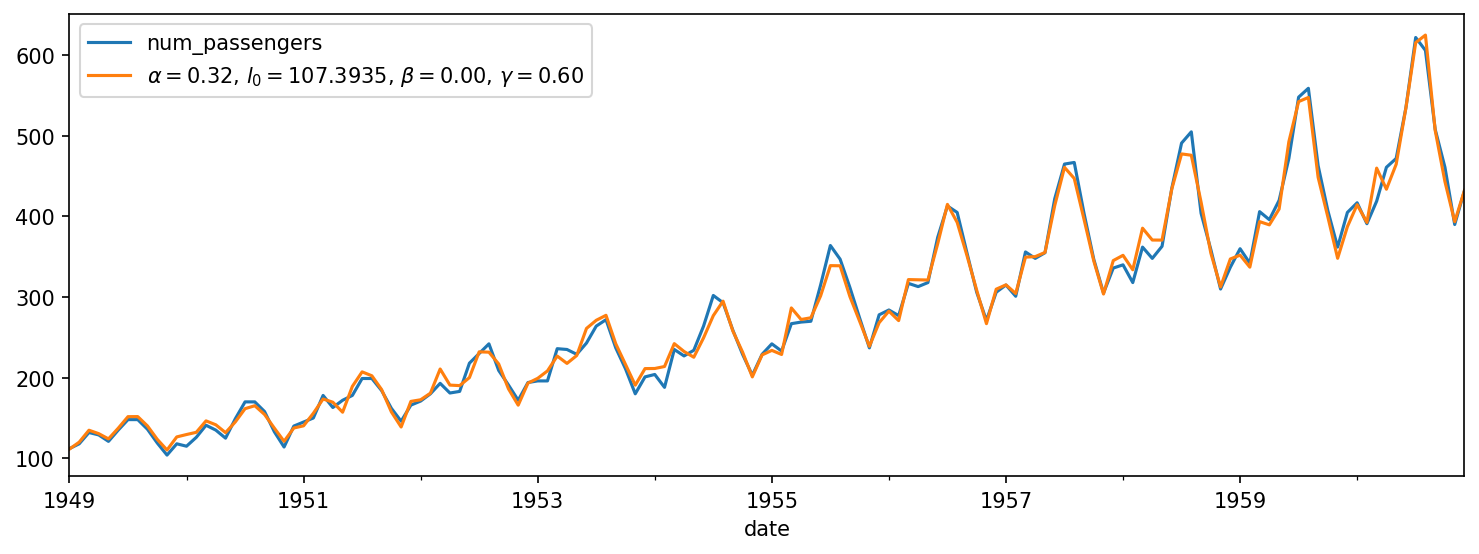

In [115]:
plt.figure(figsize=(12, 4), dpi=150)
passengers['num_passengers'].plot(legend=True)
es.fittedvalues.rename(r'$\alpha=%.2f$' % es.model.params['smoothing_level'] + ', ' +
                        r'$l_0=%.4f$' % es.model.params['initial_level'] + ', ' +
                        r'$\beta=%.2f$' % es.model.params['smoothing_trend'] + ', ' +
                        r'$\gamma=%.2f$' % es.model.params['smoothing_seasonal']).plot(legend=True)
plt.show()

In [116]:
from statsmodels.tools.eval_measures import mse

In [91]:
mse(passengers['num_passengers'], es.fittedvalues)

110.7838919222437

In [92]:
np.mean((passengers['num_passengers']-es.fittedvalues)**2)

110.7838919222437

In [20]:
start = passengers.index[-1] - pd.DateOffset(months=11) + pd.DateOffset(years=1)
end = start + pd.DateOffset(months=35)
start, end

(Timestamp('1961-01-01 00:00:00'), Timestamp('1963-12-01 00:00:00'))

In [26]:
forecast=es.forecast(36)

In [27]:
pd.to_datetime(forecast.index)

DatetimeIndex(['1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01',
               '1961-05-01', '1961-06-01', '1961-07-01', '1961-08-01',
               '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01',
               '1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01',
               '1962-05-01', '1962-06-01', '1962-07-01', '1962-08-01',
               '1962-09-01', '1962-10-01', '1962-11-01', '1962-12-01',
               '1963-01-01', '1963-02-01', '1963-03-01', '1963-04-01',
               '1963-05-01', '1963-06-01', '1963-07-01', '1963-08-01',
               '1963-09-01', '1963-10-01', '1963-11-01', '1963-12-01'],
              dtype='datetime64[ns]', freq='MS')

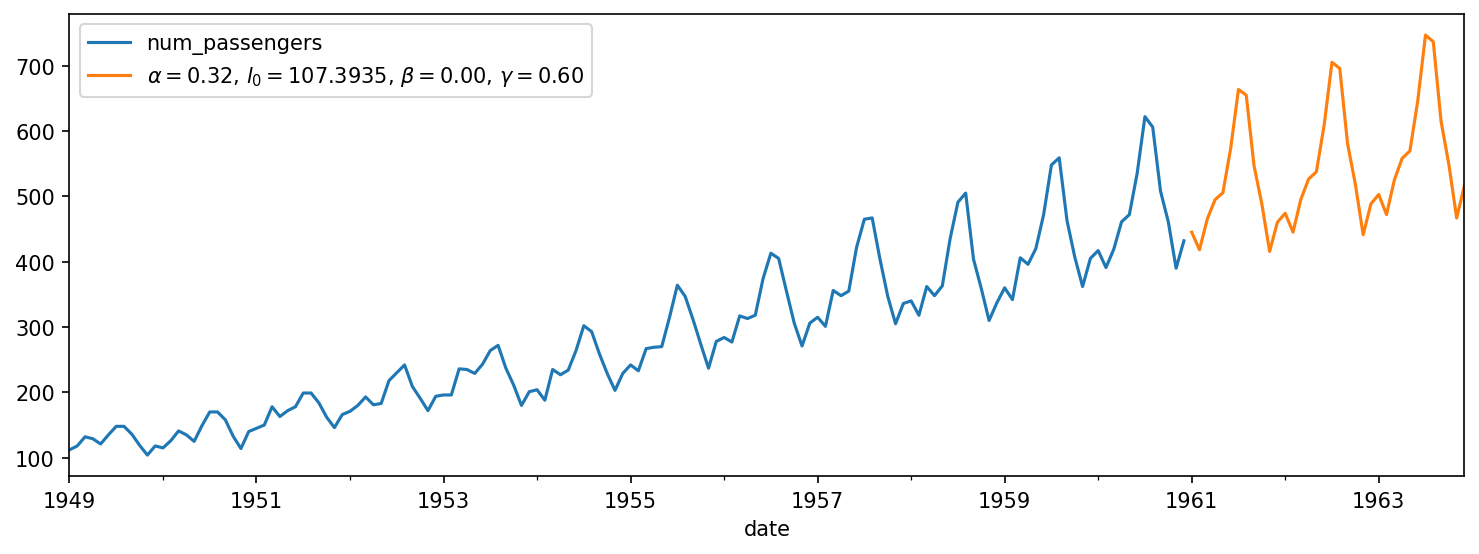

In [22]:
plt.figure(figsize=(12,4), dpi=150)
passengers['num_passengers'].plot(legend=True)
forecast.rename(r'$\alpha=%.2f$' % es.model.params['smoothing_level'] + ', ' +
                r'$l_0=%.4f$' % es.model.params['initial_level'] + ', ' +
                r'$\beta=%.2f$' % es.model.params['smoothing_trend'] + ', ' +
                r'$\gamma=%.2f$' % es.model.params['smoothing_seasonal']).plot(legend=True)
plt.show()

<div class="alert alert-warning">

<h3> Домашнее задание</h3>    
    
<p></p> 
Выполнять в отдельном файле!
    
<ul>1. Для <b>своего</b> ряда (см. папку Данные на de.unecon) определите наилучшую адаптивную модель прогнозирования. Для этого загрузите данные и отобразите их на графике. Есть ли в ряде тренд, сезонность?</ul>
    
<ul>2. С помощью библиотеки statsmodels обучите выбранную модель и постройте прогноз. Отобразите результат на графике.</ul>
    
<ul>3. Вычислите среднеквадратичную ошибку для оценки качества аппроксимации.</ul>
<p></p>
  
</div>